In [1]:
import inspect
from finta import TA
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

from yellowbrick.classifier import ConfusionMatrix

In [2]:
all_data = pd.read_csv('../data/sandp500_tickers.csv',
                       usecols=['datadate', 'tic', 'cshtrd', 'prcod', 'prccd', 'prchd', 'prcld'],
                       parse_dates=['datadate'],
                      )

In [3]:
all_data.dropna(inplace=True)

In [4]:
all_data.columns = ['date', 'tic', 'volume', 'close', 'high', 'low', 'open']

In [5]:
#all_data.set_index(['date'], inplace=True)

In [6]:
current_tickers = all_data[all_data.date == '2019-09-20'].tic.unique()

In [7]:
current_tickers = [tic for tic in current_tickers if '.' not in tic]

In [8]:
current_tickers = pd.DataFrame(current_tickers, columns=['tic'])

In [9]:
current_sandp = pd.merge(all_data, current_tickers, how='inner')

In [10]:
counts = current_sandp.tic.value_counts()

In [11]:
keep_sandp = pd.DataFrame(counts[counts >= 2400].index, columns=['tic'])

In [12]:
current_sandp = pd.merge(current_sandp, keep_sandp, how='inner')

In [13]:
current_sandp.sort_values(by=['tic', 'date'], inplace=True)

In [14]:
#current_sandp['next_open']=current_sandp.groupby('tic')['open'].shift(1)

In [15]:
current_sandp.head()

,date,tic,volume,close,high,low,open
924565,2010-01-04,A,2729240.0,31.30,31.63,31.1314,31.39
924566,2010-01-05,A,2994237.0,30.96,31.22,30.7600,31.21
924567,2010-01-06,A,2320299.0,30.85,31.00,30.7600,30.85
924568,2010-01-07,A,2214121.0,30.81,30.82,30.5000,30.78
924569,2010-01-08,A,2670856.0,30.80,30.85,30.4000,30.64


In [16]:
aapl = current_sandp.copy()
#[current_sandp.tic == 'AAPL'].copy()

In [17]:
aapl.set_index('date', inplace=True)

In [18]:
aapl.head(5)

,tic,volume,close,high,low,open
date,,,,,,
2010-01-04,A,2729240.0,31.30,31.63,31.1314,31.39
2010-01-05,A,2994237.0,30.96,31.22,30.7600,31.21
2010-01-06,A,2320299.0,30.85,31.00,30.7600,30.85
2010-01-07,A,2214121.0,30.81,30.82,30.5000,30.78
2010-01-08,A,2670856.0,30.80,30.85,30.4000,30.64


In [19]:
indicators = [(TA.CCI, {'period':30}),
              (TA.CCI, {'period':21}),
              (TA.CCI, {'period':14}),
              (TA.MACD, {}), 
              (TA.RSI, {'period':30}),
              (TA.RSI, {'period':21}),
              (TA.RSI, {'period':14}),
              (TA.ADL, {}),
              #(TA.EV_MACD, {})
             ]

In [20]:
'_'.join([str(val) for val in indicators[0][1].values()])

'30'

In [21]:
ta_functions = inspect.getmembers(TA, predicate=inspect.ismethod)

In [22]:
# skip_ta = ('ALMA', 'EVWMA', 'EVWMA', 'EV_MACD', 'FRAMA', 'LWMA', 'MAMA', 'SWI', 'TMF', 'VR',)
# indicators = [(ta[1], {}) for ta in ta_functions if ta[0] not in skip_ta]

In [23]:
#inspect.getfullargspec(TA.CCI)

In [24]:
from tqdm import tqdm

In [25]:
aapl.reset_index(inplace=True)

In [26]:
final_df = []
for ticker in tqdm(aapl.tic.unique()):
    ta_list = []
    ta_df = aapl[aapl.tic == ticker]
    ta_df.set_index('date', inplace=True)
    for count, indicator in enumerate(indicators):
        try:
            #print(indicator)
            ta_results = indicator[0](ta_df, **indicator[1])
            ta_args = '_'.join([str(val) for val in indicator[1].values()])
            #ta_results = ta_results.add_suffix('{}_{}'.format(indicator[0].__name__, ta_args))
            if isinstance(ta_results, pd.Series):
                #if ta_results.name:
                new_name = (ta_results.name or indicator[0].__name__) + '_' + ta_args
                ta_results.rename(new_name, inplace=True)
                #print(ta_results.name)
            ta_list.append(ta_results)
        except NotImplementedError as e:
            print(e)
    final_df.append(ta_df.join(ta_list))

100%|██████████| 442/442 [00:53<00:00,  9.10it/s]


In [27]:
final = pd.concat(final_df)

In [28]:
final.columns

Index(['tic', 'volume', 'close', 'high', 'low', 'open', '30 period CCI_30',
       '21 period CCI_21', '14 period CCI_14', 'MACD', 'SIGNAL', 'RSI_30',
       'RSI_21', 'RSI_14', 'MFV_'],
      dtype='object')

In [29]:
final.shape

(1081109, 15)

In [32]:
aapl_firsts = final.groupby(['tic'])[['tic', 'close', 'high', 'low', 'open']].resample('1m').first()

In [33]:
cols = ['30 period CCI_30', '21 period CCI_21', '14 period CCI_14', 'MACD', 'SIGNAL', 'RSI_30', 'RSI_21', 'RSI_14', 'MFV_']
aapl_mean= final.groupby(['tic'])[cols].resample('1m').mean()

In [34]:
aapl_sum= final.groupby(['tic'])[['volume']].resample('1m').sum()

In [35]:
aapl_all=pd.concat([aapl_firsts,aapl_mean, aapl_sum], axis=1)

In [36]:
aapl_all.head()

tic  close   high      low   open  30 period CCI_30  \
tic date                                                             
A   2010-01-31   A  31.30  31.63  31.1314  31.39        -79.431503   
    2010-02-28   A  29.13  29.32  28.1300  28.16          8.530224   
    2010-03-31   A  32.09  32.13  31.4300  31.43        106.482094   
    2010-04-30   A  34.55  34.87  34.2500  34.54        103.617392   
    2010-05-31   A  36.77  36.89  36.3700  36.50        -73.001477   

                21 period CCI_21  14 period CCI_14      MACD    SIGNAL  \
tic date                                                                 
A   2010-01-31        -79.431503        -76.739788 -0.090456 -0.049555   
    2010-02-28         27.906036         47.853030 -0.046036 -0.133512   
    2010-03-31         97.117092         95.002380  0.746314  0.647381   
    2010-04-30         91.900319         62.078502  0.672877  0.671609   
    2010-05-31        -70.195572        -70.460715 -0.265806  0.031018   

                   RSI_30     RSI_21     RSI_14          MFV_      volume  
tic date                                                                   
A   2010-01-31  21.977887  22.167983  22.354790 -3.921754e+06  57195750.0  
    2010-02-28  50.976560  54.266663  58.994975 -8.045354e+06  77437416.0  
    2010-03-31  71.249902  74.119115  75.979051 -4.642447e+05  85940921.0  
    2010-04-30  65.896845  65.189972  63.838722 -1.526734e+06  76014979.0  
    2010-05-31  43.897317  41.582252  39.448990  1.081992e+07  89202413.0

In [37]:
aapl_all['nextwk_roi'] = ((aapl_all.groupby('tic')['close'].shift(-1)-aapl_all.open) / aapl_all.open) * 100

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'tic' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [38]:
aapl_all.head(5)

tic  close   high      low   open  30 period CCI_30  \
tic date                                                             
A   2010-01-31   A  31.30  31.63  31.1314  31.39        -79.431503   
    2010-02-28   A  29.13  29.32  28.1300  28.16          8.530224   
    2010-03-31   A  32.09  32.13  31.4300  31.43        106.482094   
    2010-04-30   A  34.55  34.87  34.2500  34.54        103.617392   
    2010-05-31   A  36.77  36.89  36.3700  36.50        -73.001477   

                21 period CCI_21  14 period CCI_14      MACD    SIGNAL  \
tic date                                                                 
A   2010-01-31        -79.431503        -76.739788 -0.090456 -0.049555   
    2010-02-28         27.906036         47.853030 -0.046036 -0.133512   
    2010-03-31         97.117092         95.002380  0.746314  0.647381   
    2010-04-30         91.900319         62.078502  0.672877  0.671609   
    2010-05-31        -70.195572        -70.460715 -0.265806  0.031018   

                   RSI_30     RSI_21     RSI_14          MFV_      volume  \
tic date                                                                    
A   2010-01-31  21.977887  22.167983  22.354790 -3.921754e+06  57195750.0   
    2010-02-28  50.976560  54.266663  58.994975 -8.045354e+06  77437416.0   
    2010-03-31  71.249902  74.119115  75.979051 -4.642447e+05  85940921.0   
    2010-04-30  65.896845  65.189972  63.838722 -1.526734e+06  76014979.0   
    2010-05-31  43.897317  41.582252  39.448990  1.081992e+07  89202413.0   

                nextwk_roi  
tic date                    
A   2010-01-31   -7.199745  
    2010-02-28   13.955966  
    2010-03-31    9.926822  
    2010-04-30    6.456283  
    2010-05-31  -13.753425

In [41]:
aapl_all.shape

(51272, 16)

In [40]:
aapl_all.dropna(inplace=True)

In [42]:
aapl_all.head()

tic  close   high      low   open  30 period CCI_30  \
tic date                                                             
A   2010-01-31   A  31.30  31.63  31.1314  31.39        -79.431503   
    2010-02-28   A  29.13  29.32  28.1300  28.16          8.530224   
    2010-03-31   A  32.09  32.13  31.4300  31.43        106.482094   
    2010-04-30   A  34.55  34.87  34.2500  34.54        103.617392   
    2010-05-31   A  36.77  36.89  36.3700  36.50        -73.001477   

                21 period CCI_21  14 period CCI_14      MACD    SIGNAL  \
tic date                                                                 
A   2010-01-31        -79.431503        -76.739788 -0.090456 -0.049555   
    2010-02-28         27.906036         47.853030 -0.046036 -0.133512   
    2010-03-31         97.117092         95.002380  0.746314  0.647381   
    2010-04-30         91.900319         62.078502  0.672877  0.671609   
    2010-05-31        -70.195572        -70.460715 -0.265806  0.031018   

                   RSI_30     RSI_21     RSI_14          MFV_      volume  \
tic date                                                                    
A   2010-01-31  21.977887  22.167983  22.354790 -3.921754e+06  57195750.0   
    2010-02-28  50.976560  54.266663  58.994975 -8.045354e+06  77437416.0   
    2010-03-31  71.249902  74.119115  75.979051 -4.642447e+05  85940921.0   
    2010-04-30  65.896845  65.189972  63.838722 -1.526734e+06  76014979.0   
    2010-05-31  43.897317  41.582252  39.448990  1.081992e+07  89202413.0   

                nextwk_roi  
tic date                    
A   2010-01-31   -7.199745  
    2010-02-28   13.955966  
    2010-03-31    9.926822  
    2010-04-30    6.456283  
    2010-05-31  -13.753425

In [43]:
# drop large return outliers
aapl_all = aapl_all[(aapl_all.nextwk_roi.abs() < 50)]

In [44]:
X = aapl_all.nextwk_roi.values.reshape(-1, 1)

In [45]:
sil_scores = {}
for i in tqdm(range(2, 10)):
    k_means = KMeans(n_clusters=i)
    k_means.fit(X)
    y_hat = k_means.predict(X)
    labels = k_means.labels_
    silhouette = silhouette_score(X, labels)
    sil_scores[i] = silhouette

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [401]:
sorted(sil_scores.items(), key=lambda x: x[1], reverse=True)

[(9, 0.5304155481789161),
 (3, 0.5301239880859581),
 (6, 0.5267693427802397),
 (5, 0.5229928568850736),
 (8, 0.5215245999794305),
 (7, 0.5142350663362891),
 (4, 0.507566952341881),
 (2, 0.5013257454677106)]

In [46]:
k_means = KMeans(n_clusters=3)
k_means.fit(X)
y_hat = k_means.predict(X)
labels = k_means.labels_

In [47]:
aapl_all['roi_class'] = labels

In [48]:
aapl_all.head()

tic  close   high      low   open  30 period CCI_30  \
tic date                                                             
A   2010-01-31   A  31.30  31.63  31.1314  31.39        -79.431503   
    2010-02-28   A  29.13  29.32  28.1300  28.16          8.530224   
    2010-03-31   A  32.09  32.13  31.4300  31.43        106.482094   
    2010-04-30   A  34.55  34.87  34.2500  34.54        103.617392   
    2010-05-31   A  36.77  36.89  36.3700  36.50        -73.001477   

                21 period CCI_21  14 period CCI_14      MACD    SIGNAL  \
tic date                                                                 
A   2010-01-31        -79.431503        -76.739788 -0.090456 -0.049555   
    2010-02-28         27.906036         47.853030 -0.046036 -0.133512   
    2010-03-31         97.117092         95.002380  0.746314  0.647381   
    2010-04-30         91.900319         62.078502  0.672877  0.671609   
    2010-05-31        -70.195572        -70.460715 -0.265806  0.031018   

                   RSI_30     RSI_21     RSI_14          MFV_      volume  \
tic date                                                                    
A   2010-01-31  21.977887  22.167983  22.354790 -3.921754e+06  57195750.0   
    2010-02-28  50.976560  54.266663  58.994975 -8.045354e+06  77437416.0   
    2010-03-31  71.249902  74.119115  75.979051 -4.642447e+05  85940921.0   
    2010-04-30  65.896845  65.189972  63.838722 -1.526734e+06  76014979.0   
    2010-05-31  43.897317  41.582252  39.448990  1.081992e+07  89202413.0   

                nextwk_roi  roi_class  
tic date                               
A   2010-01-31   -7.199745          0  
    2010-02-28   13.955966          2  
    2010-03-31    9.926822          2  
    2010-04-30    6.456283          2  
    2010-05-31  -13.753425          0

In [281]:
aapl_ohlc = aapl.groupby(['tic'])['close'].resample('1w').ohlc()

In [282]:
aapl_vol = aapl.groupby(['tic'])['volume'].resample('1w').ohlc()

In [283]:
aapl_ohlc.reset_index(inplace=True)
aapl_vol.reset_index(inplace=True)

In [284]:
aapl_weekly = pd.merge(aapl_ohlc, aapl_vol, how='inner', on=['tic', 'date'], suffixes=('_price', '_vol'))

In [286]:
aapl_weekly.drop(columns=['open_vol','high_vol', 'low_vol'], inplace=True)

In [287]:
aapl_weekly.columns = ['tic', 'date', 'open', 'high', 'low', 'close', 'volume']

In [288]:
aapl_weekly['roi'] = ((aapl_weekly.close - aapl_weekly.open) / aapl_weekly.open) * 100

In [49]:
aapl_all.groupby('roi_class').mean()

,close,high,low,open,30 period CCI_30,21 period CCI_21,14 period CCI_14,MACD,SIGNAL,RSI_30,RSI_21,RSI_14,MFV_,volume,nextwk_roi
roi_class,,,,,,,,,,,,,,,
0,81.497597,82.579935,80.675347,81.817039,-52.690114,-51.651437,-45.311968,-0.675245,-0.415986,43.567318,42.085594,40.584161,2.397247e+08,1.242840e+08,-9.417667
1,82.570069,83.370082,81.716250,82.590068,21.199046,17.888073,14.036252,0.329194,0.329664,53.324032,53.401526,53.451937,7.670848e+07,8.750169e+07,1.117474
2,79.809178,80.598949,78.648087,79.487640,68.378188,66.701852,60.337200,0.884385,0.611089,59.341051,61.278587,63.358957,2.587971e+08,1.108418e+08,10.939641


In [295]:
#aapl_weekly.sort_values(['tic','date'], inplace=True)

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
#aapl['roi_class_shift1'] = aapl.roi_class.shift(-1)

In [296]:
#aapl_weekly['roi_tomorrow']=aapl_weekly.groupby('tic')['roi_class'].shift(-1)

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [298]:
#aapl_weekly.head()

,tic,date,open,high,low,close,volume,roi,roi_class,roi_tomorrow
0,A,2010-01-10,31.30,31.30,30.80,30.80,2670856.0,-1.597444,0,4.0
1,A,2010-01-17,30.82,31.15,30.43,30.43,3309434.0,-1.265412,4,0.0
2,A,2010-01-24,30.80,30.80,29.17,29.17,3049271.0,-5.292208,0,0.0
3,A,2010-01-31,29.45,29.45,28.03,28.03,4236738.0,-4.821732,0,4.0
4,A,2010-02-07,29.13,29.54,29.07,29.17,6828734.0,0.137315,4,1.0


In [152]:
#aapl.set_index(['date'], inplace=True)
#aapl.reset_index(inplace=True)

In [78]:
#for ticker in aapl.tic.unique():
#print(TA.CCI(aapl[aapl['tic']=='ZION'], period=30))
#    break

1078663           NaN
1078664     47.140452
1078665     73.289767
1078666     90.481873
1078667     68.107945
1078668     65.914586
1078669     50.435587
1078670     35.395287
1078671     58.160619
1078672     45.344927
1078673     59.197478
1078674     88.562178
1078675    114.208327
1078676     68.074836
1078677     57.963763
1078678    124.275742
1078679     89.450768
1078680     97.349769
1078681     84.068684
1078682     94.763205
1078683     93.723035
1078684     60.070217
1078685     15.218398
1078686     18.488179
1078687     31.414032
1078688     35.219015
1078689     40.427152
1078690     33.589303
1078691     14.960668
1078692     26.210587
              ...    
1081079   -108.058577
1081080   -124.299245
1081081   -107.205860
1081082   -145.491844
1081083   -140.702073
1081084   -113.183938
1081085    -80.230995
1081086    -84.242840
1081087    -68.312488
1081088    -55.960071
1081089    -73.807921
1081090    -78.761372
1081091    -82.650641
1081092    -80.297757
1081093   

In [31]:
#aapl_real = aapl[aapl.tic == 'AAPL']
#a_real = aapl[aapl.tic == 'A']

In [56]:
#aapl.set_index('tic', inplace=True)
#aapl.reset_index(inplace=True)

In [32]:
#aapl.set_index(['date'], inplace=True)

In [33]:
#a_real.set_index('date', inplace=True)
#aapl_real.set_index('date', inplace=True)

In [34]:
#aapl_real['cci_30'] = TA.CCI(aapl_real, period=30)
#a_real['cci_30'] = TA.CCI(a_real, period=30)

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
#cci_gb=aapl.groupby('tic').apply(lambda x: TA.CCI(x, period=30)).reset_index().set_index('date', 'tic')
#macd=aapl.groupby('tic').apply(lambda x: TA.MACD(x, period_slow=15, period_fast=30)).reset_index().set_index('date', 'tic')

In [ ]:
#aapl.reset_index().set_index(['date', 'tic'], inplace=True)
#aapl = aapl.join([cci_gb, macd])

In [210]:
#cci_gb=aapl.groupby('tic').apply(lambda x: TA.CCI(x, period=30)).reset_index().set_index('date', 'tic', inplace=True)

AttributeError: 'NoneType' object has no attribute 'groupby'

In [204]:
#cci_gb.set_index('date', 'tic', inplace=True)

In [163]:
#aapl['cci_30'] = TA.CCI(aapl, period=30)

In [189]:
#aapl.loc[(aapl.date=='2010-01-08') & (aapl.tic =='AAPL')]

,date,tic,volume,close,high,low,open,roi,roi_class,roi_tomorrow,cci_30,30 period CCI
4896,2010-01-08,AAPL,15972090.0,211.98,212.0,209.06,210.3,0.798859,0,3.0,136.496794,-55.23632


In [34]:
macd = TA.MACD(aapl, period_slow=15, period_fast=30)

In [35]:
aapl = pd.concat([aapl, macd], axis=1)

In [36]:
aapl['rsi_14'] = TA.RSI(aapl, 14)

In [38]:
final.dropna(inplace=True)

In [39]:
final = final['2010-02-01':]

In [40]:
final.head()

,tic,volume,close,high,low,open,roi,roi_class,roi_tomorrow,20 period CCI,MACD,SIGNAL,RSI
date,,,,,,,,,,,,,
2010-02-01,A,3993209.0,29.13,29.32,28.13,28.16,3.444602,4,2.0,-97.975511,-0.371707,-0.243427,42.071131
2010-02-02,A,4209397.0,29.50,29.59,29.09,29.22,0.958248,2,0.0,-52.239127,-0.332231,-0.261353,48.340215
2010-02-03,A,4353100.0,29.54,29.89,29.36,29.39,0.510378,0,1.0,-31.795150,-0.295026,-0.268137,49.028304
2010-02-04,A,4744169.0,29.07,29.45,28.94,29.30,-0.784983,1,2.0,-60.968184,-0.294605,-0.273462,41.528882
2010-02-05,A,6828734.0,29.17,29.26,28.18,28.91,0.899343,2,0.0,-75.678973,-0.283926,-0.275565,43.645111


In [53]:
aapl_all.groupby('roi_class').mean()

,close,high,low,open,30 period CCI_30,21 period CCI_21,14 period CCI_14,MACD,SIGNAL,RSI_30,RSI_21,RSI_14,MFV_,volume,nextwk_roi
roi_class,,,,,,,,,,,,,,,
gain,79.809178,80.598949,78.648087,79.487640,68.378188,66.701852,60.337200,0.884385,0.611089,59.341051,61.278587,63.358957,2.587971e+08,1.108418e+08,10.939641
loss,81.497597,82.579935,80.675347,81.817039,-52.690114,-51.651437,-45.311968,-0.675245,-0.415986,43.567318,42.085594,40.584161,2.397247e+08,1.242840e+08,-9.417667
neutral,82.570069,83.370082,81.716250,82.590068,21.199046,17.888073,14.036252,0.329194,0.329664,53.324032,53.401526,53.451937,7.670848e+07,8.750169e+07,1.117474


In [51]:
aapl_all.loc[aapl_all.roi_class == 0, 'roi_class'] = 'loss'

In [52]:
aapl_all.loc[aapl_all.roi_class == 1, 'roi_class'] = 'neutral'
aapl_all.loc[aapl_all.roi_class == 2, 'roi_class'] = 'gain'

In [54]:
aapl_all.head()

tic  close   high      low   open  30 period CCI_30  \
tic date                                                             
A   2010-01-31   A  31.30  31.63  31.1314  31.39        -79.431503   
    2010-02-28   A  29.13  29.32  28.1300  28.16          8.530224   
    2010-03-31   A  32.09  32.13  31.4300  31.43        106.482094   
    2010-04-30   A  34.55  34.87  34.2500  34.54        103.617392   
    2010-05-31   A  36.77  36.89  36.3700  36.50        -73.001477   

                21 period CCI_21  14 period CCI_14      MACD    SIGNAL  \
tic date                                                                 
A   2010-01-31        -79.431503        -76.739788 -0.090456 -0.049555   
    2010-02-28         27.906036         47.853030 -0.046036 -0.133512   
    2010-03-31         97.117092         95.002380  0.746314  0.647381   
    2010-04-30         91.900319         62.078502  0.672877  0.671609   
    2010-05-31        -70.195572        -70.460715 -0.265806  0.031018   

                   RSI_30     RSI_21     RSI_14          MFV_      volume  \
tic date                                                                    
A   2010-01-31  21.977887  22.167983  22.354790 -3.921754e+06  57195750.0   
    2010-02-28  50.976560  54.266663  58.994975 -8.045354e+06  77437416.0   
    2010-03-31  71.249902  74.119115  75.979051 -4.642447e+05  85940921.0   
    2010-04-30  65.896845  65.189972  63.838722 -1.526734e+06  76014979.0   
    2010-05-31  43.897317  41.582252  39.448990  1.081992e+07  89202413.0   

                nextwk_roi roi_class  
tic date                              
A   2010-01-31   -7.199745      loss  
    2010-02-28   13.955966      gain  
    2010-03-31    9.926822      gain  
    2010-04-30    6.456283      gain  
    2010-05-31  -13.753425      loss

In [55]:
aapl_all.columns

Index(['tic', 'close', 'high', 'low', 'open', '30 period CCI_30',
       '21 period CCI_21', '14 period CCI_14', 'MACD', 'SIGNAL', 'RSI_30',
       'RSI_21', 'RSI_14', 'MFV_', 'volume', 'nextwk_roi', 'roi_class'],
      dtype='object')

In [56]:
X = aapl_all.loc[:, '30 period CCI_30':'MFV_']

In [57]:
poly = PolynomialFeatures(degree=3)
Xp = poly.fit_transform(X)

In [58]:
y = aapl_all.roi_class

In [59]:
X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size = 0.2)

In [60]:
sd = StandardScaler()
X_train = sd.fit_transform(X_train)
X_test = sd.fit_transform(X_test)

In [61]:
X_train.shape

(40955, 220)

In [62]:
clf = LogisticRegression(n_jobs=-1, solver='lbfgs').fit(X_train, y_train)

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [63]:
clf.score(X_train, y_train)

0.7400073251129288

In [64]:
clf.score(X_test, y_test)

0.7402090047856236

In [65]:
y_pred = clf.predict(X_test)

In [66]:
confusion_matrix(y_test, y_pred)

array([[1335,    7,  944],
       [   5, 1369,  848],
       [ 517,  339, 4875]])

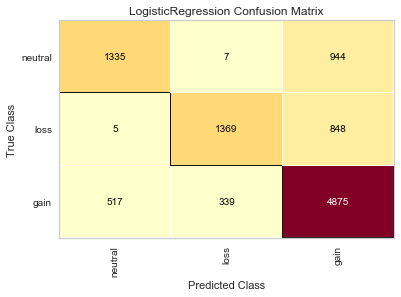

In [67]:
cm = ConfusionMatrix(clf, classes=['neutral', 'loss', 'gain'])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof();

In [68]:
aapl_all.to_pickle('clean_data/sandp_ta.plk')

### Random Forest 

In [619]:
poly = PolynomialFeatures(degree=2)
Xp = poly.fit_transform(X)

In [620]:
rfc = RandomForestClassifier(n_estimators=100, max_features= 'auto', max_depth=7,  oob_score=True)

In [622]:
cv = cross_validate(rfc, Xp, y,return_estimator= True, cv=None, n_jobs=-1)

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [623]:
cv['test_score']

array([0.65612044, 0.65468475, 0.65689866])

In [624]:
est_list = [est for est in cv['estimator']]

In [625]:
[est.oob_score_ for est in est_list]

[0.655362342175529, 0.6576768774570972, 0.6558722108172658]

### SVC

In [626]:
from sklearn.svm import SVC

In [627]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [372]:
X = sandp.roi.values.reshape(-1, 1)

In [373]:
sil_scores = {}
for i in range(2, 20):
    k_means = KMeans(n_clusters=i)
    k_means.fit(X)
    y_hat = k_means.predict(X)
    labels = k_means.labels_
    silhouette = silhouette_score(X, labels)
    sil_scores[i] = silhouette

In [374]:
sorted(sil_scores.items(), key=lambda x: x[1], reverse=True)[:3]

[(3, 0.5672729226191421), (17, 0.5385505156853061), (16, 0.5357662401200405)]

In [192]:
k_means = KMeans(n_clusters=3)
k_means.fit(X)
y_hat = k_means.predict(X)
labels = k_means.labels_

In [194]:
sandp['roi_class'] = labels

In [196]:
sandp.groupby('roi_class').mean()

,open,high,low,close,adj_close,volume,roi
roi_class,,,,,,,
0,1997.545528,2004.178918,1989.908481,1997.690351,1997.690351,3.565922e+09,0.006699
1,1804.376123,1807.631245,1772.956191,1778.496059,1778.496059,4.256878e+09,-1.465127
2,1771.293355,1794.015278,1768.001967,1791.420355,1791.420355,3.924541e+09,1.177166


In [118]:
#sandp = pd.concat([sandp, TA.SMA(sandp, 42)], axis=1)
#sandp.loc[:, ['close', '42 period SMA']].plot.line()

In [226]:
TA.CCI(sandp, period=30)

date
2010-01-04           NaN
2010-01-05     47.140452
2010-01-06     55.027085
2010-01-07     59.207938
2010-01-08     78.144763
2010-01-11     89.865533
2010-01-12     -3.539732
2010-01-13     49.831199
2010-01-14     90.246711
2010-01-15     -8.541302
2010-01-19     65.889605
2010-01-20    -14.296739
2010-01-21   -138.127271
2010-01-22   -196.500593
2010-01-25   -153.676332
2010-01-26   -133.612293
2010-01-27   -120.872314
2010-01-28   -121.582136
2010-01-29   -125.054506
2010-02-01   -104.252295
2010-02-02    -61.249369
2010-02-03    -60.472610
2010-02-04   -114.529883
2010-02-05   -136.228139
2010-02-08   -119.103977
2010-02-09    -93.632167
2010-02-10    -94.364289
2010-02-11    -77.653586
2010-02-12    -76.436788
2010-02-16    -36.965928
                 ...    
2019-08-09    -78.856099
2019-08-12   -115.419152
2019-08-13    -72.705653
2019-08-14   -135.217746
2019-08-15   -136.832895
2019-08-16    -84.804237
2019-08-19    -36.639352
2019-08-20    -50.493576
2019-08-21    -30.23

In [133]:
TA.MACD(sandp, period_slow=15, period_fast=30)

,MACD,SIGNAL
date,,
2010-01-04,0.000000,0.000000
2010-01-05,-0.058834,-0.032685
2010-01-06,-0.089832,-0.056106
2010-01-07,-0.223154,-0.112694
2010-01-08,-0.389150,-0.194934
2010-01-11,-0.547742,-0.290564
2010-01-12,-0.290884,-0.290645
2010-01-13,-0.436178,-0.325619
2010-01-14,-0.633902,-0.396834


In [227]:
TA.RSI(sandp, 14)

date
2010-01-04           NaN
2010-01-05    100.000000
2010-01-06    100.000000
2010-01-07    100.000000
2010-01-08    100.000000
2010-01-11    100.000000
2010-01-12     46.205695
2010-01-13     65.197803
2010-01-14     68.918483
2010-01-15     44.418495
2010-01-19     62.153238
2010-01-20     47.227071
2010-01-21     31.693988
2010-01-22     22.084502
2010-01-25     27.252771
2010-01-26     25.463095
2010-01-27     31.467022
2010-01-28     25.662937
2010-01-29     21.842239
2010-02-01     37.317250
2010-02-02     48.226592
2010-02-03     44.414108
2010-02-04     29.296119
2010-02-05     31.713552
2010-02-08     28.289295
2010-02-09     39.314247
2010-02-10     38.140754
2010-02-11     46.162705
2010-02-12     44.266584
2010-02-16     57.454948
                 ...    
2019-08-09     43.780374
2019-08-12     36.430177
2019-08-13     48.528445
2019-08-14     33.899604
2019-08-15     35.725255
2019-08-16     45.852096
2019-08-19     53.108801
2019-08-20     48.178998
2019-08-21     53.34